# Notebook on Demon Use Case for local robustness

Although Gurobi is not designed as an optimizer for simple satisfiability proofs, we demonstrate how our library can be used in such contexts. For this, we test adversarial robustness using an MNIST classifier.

First we need to import the necessary packages.

In [58]:
import numpy as np
from enncode.gurobiModelBuilder import GurobiModelBuilder
from gurobipy import GRB, quicksum
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

Then we load the original MNIST datapoint, which we test for adversarial robustness.

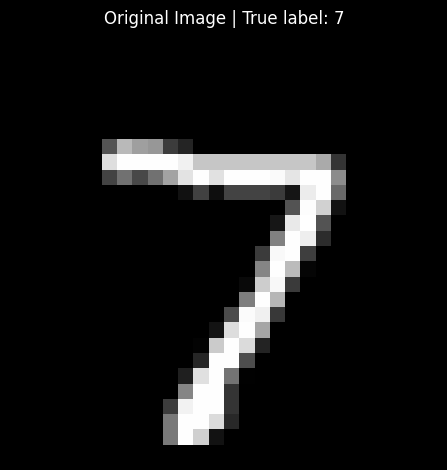

In [59]:
# 1) Load MNIST sample, display a sample image and its correct label
dataset = mnist.load_data()
images, labels = dataset[1]
image = images[0]
label = labels[0]
image_array = np.array(image, dtype=np.float32) / 255.0  # Convert image to a NumPy array and normalize to [0, 1]

plt.imshow(image_array, cmap="gray")
plt.title(f"Original Image | True label: {label}")
plt.axis("off")
plt.tight_layout()
plt.show()

We define the stringency of the robustness test by the following parameters.

In [60]:
# 2) Define a slight perturbation of an input image
eps = 0.1 # Each pixel is allowed to be changed by the value epsilon.
delta = 0.01 # A small margin delta to enforce misclassification
M = 1e5 # Big-M (large constant)

Then we initialize the Gurobi model by passing the desired network as ONNX path to the _GurobiModelBuilder_ constructor,

In [61]:
# 3) Convert the ONNX model to a Gurobi model
model_builder = GurobiModelBuilder("data/mnist_classifier.onnx")
model_builder.build_model()
gurobi_model = model_builder.get_gurobi_model()

We then obtain the input variables. For these, we define the allowed epsilon deviation.

In [62]:
# 4) Provide input data with defined perturbation
input_vars = model_builder.get_input_vars()
if input_vars is None:
    raise ValueError("No variables found for input tensor.")

input_image_array = image_array.reshape(1, 1, 28, 28).astype(np.float32)
input_shape = input_image_array.shape
for idx, var in input_vars.items():
    if isinstance(idx, int):
        md_idx = np.unravel_index(idx, input_shape[1:])  # Exclude batch dimension
    else:
        md_idx = idx
    original_value = float(input_image_array[0, *md_idx])
    lb = max(0.0, original_value - eps)
    ub = min(1.0, original_value + eps)
    gurobi_model.addConstr(var >= lb, name=f"input_lb_{idx}")
    gurobi_model.addConstr(var <= ub, name=f"input_ub_{idx}")

For the output variables, we encode the misclassification via binary variables.

In [63]:
# 5) Add misclassification constraint
output_vars = model_builder.get_output_vars()
binary_vars = {}
if output_vars is None:
    raise ValueError("No variables found for output tensor.")
for idx, var in output_vars.items():
    if isinstance(idx, tuple):
        class_label = idx[0]
    else:
        class_label = idx
    if class_label != label:
        binary_vars[class_label] = gurobi_model.addVar(vtype=GRB.BINARY, name=f"s_{class_label}")

for class_label, s in binary_vars.items():
    gurobi_model.addConstr(
        output_vars[(label,)] - output_vars[(class_label,)] <= -delta + M*(1 - s),
        name=f"{class_label}_big_M"
        )

gurobi_model.addConstr(
    quicksum(binary_vars[class_label] for class_label in binary_vars) >= 1,
    name="missclassification_constr"
    )

<gurobi.Constr *Awaiting Model Update*>

Once the encoding is done, we the optimization is performed. If Gurobi were to have the status "INFEASIBLE", then the adversarial robustness for the defined parameters at this input would be proven.

In [64]:
# 6) Optimize the model
gurobi_model.optimize()
if gurobi_model.status != GRB.OPTIMAL:
    raise ValueError(f"Model could not be optimized. Status: {gurobi_model.status}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3422 rows, 2903 columns and 208280 nonzeros
Model fingerprint: 0x6ebedb6d
Model has 256 simple general constraints
  256 MAX
Variable types: 2894 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+05]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-05, 1e+05]
Presolve removed 2872 rows and 1675 columns
Presolve time: 0.35s
Presolved: 550 rows, 1228 columns, 95566 nonzeros
Variable types: 1009 continuous, 219 integer (219 binary)

Root relaxation: objective 0.000000e+00, 201 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap

Otherwise, the assignment of the input variables holds a counterexample for the defined robustness specification. This can be obtained and visualized.

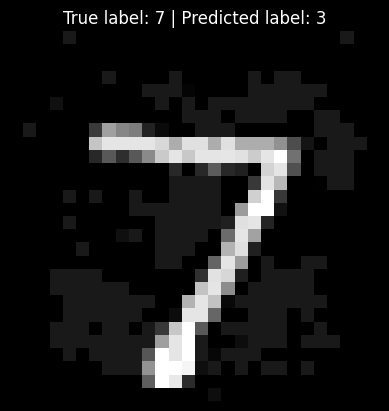

In [65]:
# 7) Retrieve outputs and display results
output_shape = model_builder.in_out_tensors_shapes["output"]
model_output = np.zeros((1,) + tuple(output_shape), dtype=np.float32)
for idx, var in output_vars.items():
    if isinstance(idx, int):
        md_idx = np.unravel_index(idx, output_shape)
    else:
        md_idx = idx
    model_output[(0,) + md_idx] = var.x

predicted_label = np.argmax(model_output[0])

adversarial_input = np.zeros_like(input_image_array, dtype=np.float32)
for idx, var in input_vars.items():
    if isinstance(idx, int):
        md_idx = np.unravel_index(idx, input_shape[1:])
    else:
        md_idx = idx
    adversarial_input[(0,) + md_idx] = var.x

plt.imshow(adversarial_input[0, 0], cmap="gray")
plt.title(f"True label: {label} | Predicted label: {predicted_label}")
plt.axis("off")
plt.show()